# Introduction
We are going to build the Value class of the micrograd library such that it automatically keeps track of our calculations such that we can easily calculate the derivatives of arbitrarily nested functions (e.g. neural networks).

# Libraries

In [1]:
%matplotlib inline

In [27]:
###VALUE###
from __future__ import annotations
import math

# Value Class
In this class we implement the simple math operations we saw in the first notebook as well as the backpropagation.

### Adding Addition and Multiplication
The math operations are added using the special/dunder methods recognized by starting and ending with \_\_.

In [3]:
# Implementing simple addition and multiplication
class Value:
    def __init__(self, data:float):
        self.data = data
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other:Value) -> Value:
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other:Value) -> Value:
        out = Value(self.data * other.data)
        return out

In [4]:
# Testing methods
print(Value(2) + Value(3))
print(Value(2) * Value(3))

Value(data=5)
Value(data=6)


### Keeping track of Expression Graphs
As mentioned in the first notebook our library needs to keep track of which values produce which other values before it can do backpropagation. This functionality is added here. Everytime an addition or multiplication has been performed the previous calculation is saved.

In [5]:
# Keeping track of previous calculations
class Value:
    def __init__(self, data:float, _children:tuple = (), _op:str = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other:Value) -> Value:
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other:Value) -> Value:
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [6]:
# Making Calculations
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c;print(d)

Value(data=4.0)


In [7]:
# Investigating the numbers were calculated
print(f'Previous calculation for d: {d._prev}')
print(f'Previous calculation for d: {d._op}')

print(f'Previous calculation for value 1: {list(d._prev)[0]._prev}')
print(f'Previous calculation for value 1: {list(d._prev)[0]._op}')

print(f'Previous calculation for value 2: {list(d._prev)[1]._prev}')
print(f'Previous calculation for value 2: {list(d._prev)[1]._op}')

Previous calculation for d: {Value(data=-6.0), Value(data=10.0)}
Previous calculation for d: +
Previous calculation for value 1: {Value(data=2.0), Value(data=-3.0)}
Previous calculation for value 1: *
Previous calculation for value 2: set()
Previous calculation for value 2: 


The tracking shows that d was calculated from two numbers: 10 and -6. We can further see that -6 was calculated by multiplying 2 and -3. It looks like the hierachical calculations are now correctly tracked. 

### Visualizing Expression Graphs
As the manuel walkthrough of previous calculations above is rather annoying to perform, here we use the **graphviz**-library to visualise the calculations instead.

In [8]:
from graphviz import Digraph

In [9]:
def trace(root: Value) -> tuple:
    """
    Description:
        Iterates recursively through the previous calculations
        from the root to the leafs and creates a tree.
    Inputs:
        root: The Value object of a forward pass
    Outputs:
        Nodes and Edges representing the calculations
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [10]:
def draw_dot(root: Value) -> Digraph:
    """
    Description:
        Creates a graph showing the relations between calculations.
    Inputs:
        root: The Value object of a forward pass
    Outputs:
        A graph representation of the calculations        
    """
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    for n in nodes:
        uid = str(id(n))
        # For each value in graph create rectangular node for it
        dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data), shape='record')
        
        # If the value is a result of a calculation create a "operation" node for it
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        # Connect the n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

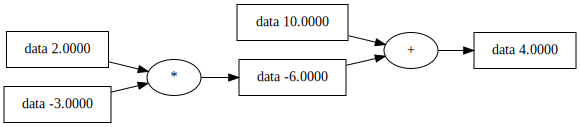

In [11]:
# Plotting calculation graph
draw_dot(d)

### Adding backpropagation
Now we add tracking of the gradients to the class, as well as the visualization. For a recap on **The Chain Rule** go to notebook 2. Intuitively the chain rule can be explained in the following way:

"if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

In [12]:
def trace(root: Value) -> tuple:
    """
    Description:
        Iterates recursively through the previous calculations
        from the root to the leafs and creates a tree.
    Inputs:
        root: The Value object of a forward pass
    Outputs:
        Nodes and Edges representing the calculations
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [42]:
def draw_dot(root: Value) -> Digraph:
    """
    Description:
        Creates a graph showing the relations between calculations.
    Inputs:
        root: The Value object of a forward pass
    Outputs:
        A graph representation of the calculations        
    """
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    for n in nodes:
        uid = str(id(n))
        # For each value in graph create rectangular node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        # If the value is a result of a calculation create a "operation" node for it
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # Connect the n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In the value class we add how to calculate the gradient for addition, multiplication and so on using the chain rule. Further we add a function for transversing the entire expression tree from root to edges calculating the gradients, thus making a backward pass. 

In [57]:
###VALUE###
class Value:
    def __init__(self, data:float, _children:tuple = (), _op:str = '', label=''):
        """
        Description:
            A value object keeps track of how the value was calculated
            as well as how to calculate the value's gradient.
        Inputs:
            data: The value of the object
            _children: The values used to calculate the self.data
            _op: The operator to calculate self.data
            label: The name of the value object
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self, other:Value) -> Value:
        """
        Description:
            Adds the current value to an input value
            and adds the calculation to the expression tree 
            plus adds how to calculate the gradient.\
        Inputs:
            other: A value
        Outputs:
            The sum of self and other
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other:Value) -> Value:
        """
        Description:
            Multiplies the current value with an input value
            and adds the calculation to the expression tree 
            plus adds how to calculate the gradient.
        Inputs:
            other: A value
        Outputs:
            The product of self and other
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward            
        
        return out
    
    def __pow__(self, other:int | float) -> Value:
        """
        Description:
            Raises the current value to the power of an input value
            and adds the calculation to the expression tree 
            plus adds how to calculate the gradient.
        Inputs:
            other: A value
        Outputs:
            The product of self and other
        """
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out  
    
    def relu(self) -> Value:
        """
        Description:
            Rounds values lower that zero to zero
            and adds the calculation to the expression tree 
            plus adds how to calculate the gradient.
        Outputs:
            The zero or the value
        """
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out     

    def tanh(self) -> Value:
        """
        Description:
            Squeezes values between -1 and 1
            and adds the calculation to the expression tree 
            plus adds how to calculate the gradient.
        Outputs:
            tanh of the value
        """
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out 
    
    def backward(self) -> None:
        """
        Description:
            Iterates backwards through the expression tree from 
            the ouput to the inputs applying the chain rule, 
            thus calculating the individual gradients with 
            respect to the output.
        """
        # Sorts topologically from root to leafs
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # Applying chain rule by going from root to leafs
        self.grad = 1
        for v in reversed(topo):
            v._backward()
    
    def __neg__(self) -> Value:
        """
        Description:
            Multiplies self with negative one.
        Outputs:
            The self value multiplied with negative one
        """
        return self * -1

    def __sub__(self, other:Value) -> Value:
        """
        Description:
            Subracts an input value from the current value
            and adds the calculation to the expression tree 
            plus adds how to calculate the gradient.
        Inputs:
            other: A value
        Outputs:
            The difference of self and other
        """
        return self + (-other)

    def __rmul__(self, other: Value) -> Value:
        """
        Description:
            Due to python's evaluation order it can calculate:
                Value * 3 <=> Value.__mul__(3)
            But not:
                3 * Value <=> 3.__mul__(Value)
            But by implementing the rmul special method a fallback
            is created that handles this by changing the evaluation
            order.
        """
        return self * other
    
    def __rsub__(self, other: Value) -> Value:
        return other + (-self)
    
    def __radd__(self, other: Value) -> Value:
        return self + other
    
    def __truediv__(self, other: Value) -> Value:
        """
        Description:
            Divides the current value with an input value
            and adds the calculation to the expression tree 
            plus adds how to calculate the gradient.
        Inputs:
            other: A value
        Outputs:
            self/other
        """
        return self * other**-1

    def __rtruediv__(self, other: Value) -> Value:
        """
        Description:
            Divides the input value with the current value
            and adds the calculation to the expression tree 
            plus adds how to calculate the gradient.
        Inputs:
            other: A value
        Outputs:
            other/self
        """
        return other * self**-1
    
    def __repr__(self):
        return f'Value(data={self.data}, data={self.grad})'

### Creating a Neuron
For testing the value class and the new visualization we here make a simple neuron.

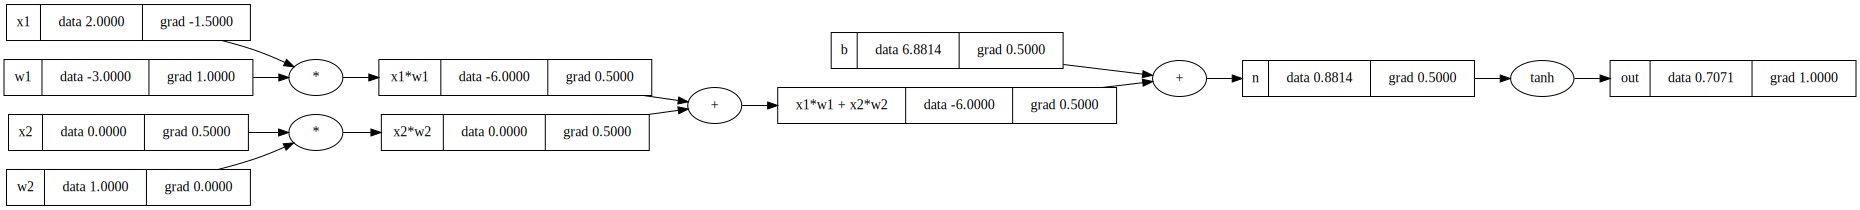

In [59]:
# Inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# Weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# Bias
b = Value(6.8813735870195432, label = 'b')

# Forward pass
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
out = n.tanh();out.label = 'out'

# Backward pass
out.backward()

draw_dot(out)

# Doing the same in Pytorch
Everything that our Value Class can do we now try out using the Pytorch library.

In [66]:
import torch

In [76]:
# Inputs
x1 = torch.Tensor([2.0]).double();x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();x2.requires_grad = True

# Weights
w1 = torch.Tensor([-3.0]).double();w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();w2.requires_grad = True

# Bias
b = torch.Tensor([6.8813735870195432]).double();b.requires_grad = True

In [77]:
# Forward pass
n = x1 * w1 + x2 * w2 + b
out = torch.tanh(n)
print(out.data.item())

0.7071066904050358


In [78]:
# Backward pass
out.backward()

In [79]:
# Printing values
print('x1 - Value:' + str(x1.data.item()) + ' Grad: ' + str(x1.grad.item()))
print('x2 - Value:' + str(x2.data.item()) + ' Grad: ' + str(x2.grad.item()))
print('w1 - Value:' + str(w1.data.item()) + ' Grad: ' + str(w1.grad.item()))
print('w2 - Value:' + str(w2.data.item()) + ' Grad: ' + str(w2.grad.item()))

x1 - Value:2.0 Grad: -1.5000003851533106
x2 - Value:0.0 Grad: 0.5000001283844369
w1 - Value:-3.0 Grad: 1.0000002567688737
w2 - Value:1.0 Grad: 0.0


The printed values should be the same as thos in the expression graph when using our module.

# Writing Cells to Module
Here we write the Value class to a module by labeling the cell with ###VALUE###.

In [80]:
!python3.10 ../../helpers/ipynb_to_py.py 3.\ Value\ Module.ipynb "###VALUE###" ../../modules/Micrograd/value.py

INFO: Cells with label ###VALUE### extracted from 3. Value Module.ipynb
